### A linear network for MNIST dataset
##### Use L2, earlystopping as well as dropout

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ES import EarlyStopping
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [49]:
import warnings
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"

### Q1

In [ ]:
x_train = idx2numpy.convert_from_file('mnist/train-images.idx3-ubyte')
y_train = idx2numpy.convert_from_file('mnist/train-labels.idx1-ubyte')
x_test = idx2numpy.convert_from_file('mnist/t10k-images.idx3-ubyte')
y_test = idx2numpy.convert_from_file('mnist/t10k-labels.idx1-ubyte')

train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).long())
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [3]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 16)
        self.fc2 = nn.Linear(16, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

model1 = Net1()
model2 = Net2()

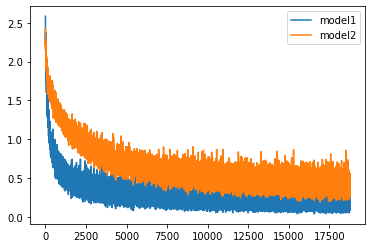

In [4]:
epoch = 20
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=lr)
optimizer2 = optim.SGD(model2.parameters(), lr=lr)

loss1 = list()
loss2 = list()

for i in range(epoch):
    for x, y in train_loader:
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        y_pred1 = model1(x)
        y_pred2 = model2(x)
        
        l1 = criterion(y_pred1, y)
        l2 = criterion(y_pred2, y)
        
        l1.backward()
        l2.backward()
        
        optimizer1.step()
        optimizer2.step()
        
        loss1.append(l1.item())
        loss2.append(l2.item())

plt.plot(loss1, label='model1')
plt.plot(loss2, label='model2')
plt.legend()
plt.show()

In [5]:
# test

model1.eval()
model2.eval()

correct1 = 0
correct2 = 0

for x, y in test_loader:
    y_pred1 = model1(x)
    y_pred2 = model2(x)
    
    y_pred1 = torch.argmax(y_pred1, dim=1)
    y_pred2 = torch.argmax(y_pred2, dim=1)
    
    correct1 += torch.sum(y_pred1 == y).item()
    correct2 += torch.sum(y_pred2 == y).item()

print('model1\'s accuracy is %.2f%%' % (100 * correct1 / len(test_data)))
print('model2\'s accuracy is %.2f%%' % (100 * correct2 / len(test_data)))

model1's accuracy is 94.70%
model2's accuracy is 88.89%


### Q2 Using Early Stopping

In [64]:
def load_mnist_sub(path, kind):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=0)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=0).reshape(len(labels), 784)

    return images, labels

x_train, y_train = load_mnist_sub('fashion_sub', kind='train_sub')
x_test, y_test = load_mnist_sub('fashion_sub', kind='test_sub')

train_data  = TensorDataset(torch.from_numpy(x_train.copy()).float(), torch.from_numpy(y_train.copy()).long())
test_data = TensorDataset(torch.from_numpy(x_test.copy()).float(), torch.from_numpy(y_test.copy()).long())

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [80]:
# using early stopping

earlystopping = EarlyStopping(patience=5, verbose=True)

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

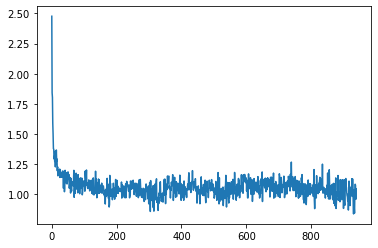

In [66]:
model3 = Net3()

epoch = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=lr)

loss3 = list()

for i in range(epoch):
    for x, y in train_loader:
        y_hat = model3(x)
        loss = criterion(y_hat, y)
        loss3.append(loss.item())
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()

plt.plot(loss3)

In [83]:
model3.eval()

val_loss = list()

for x, y in test_loader:
    y_hat = model3(x)
    loss = criterion(y_hat, y)
    val_loss.append(loss.item())
    
    earlystopping(loss, model3)
    
    if earlystopping.early_stop:
        print('Early Stopping')
        break

model3.load_state_dict(torch.load('checkpoint.pt'))
avg_val_loss = np.mean(val_loss)
print('Average validation loss is %.2f' % avg_val_loss)
print('Best validation loss is %.2f' % earlystopping.val_loss_min)

Net3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

EarlyStopping counter: 7 out of 5
Early Stopping


<All keys matched successfully>

Average validation loss is 0.90
Best validation loss is 0.89


### Q3 Using L2

In [10]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(28*28, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        x = self.l4(x)
        return x

model4 = Net4()

epoch = 20
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(model4.parameters(), lr=lr, weight_decay=0.5)
optimizer41 = optim.Adam(model4.parameters(), lr=lr, weight_decay=0.9)


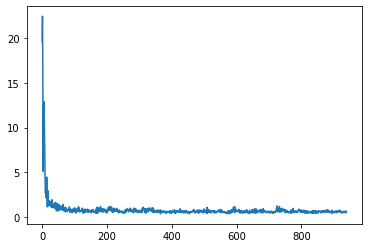

In [ ]:
loss4 = list()

for i in range(epoch):
    for x, y in train_loader:
        y_hat = model4(x)
        loss = criterion(y_hat, y)
        loss4.append(loss.item())
        optimizer4.zero_grad()
        loss.backward()
        optimizer4.step()

plt.plot(loss4)

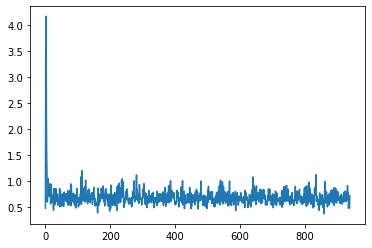

In [23]:
loss41 = list()

for i in range(epoch):
    for x, y in train_loader:
        y_hat = model4(x)
        loss = criterion(y_hat, y)
        loss41.append(loss.item())
        optimizer41.zero_grad()
        loss.backward()
        optimizer41.step()

plt.plot(loss41)

In [ ]:
model4.eval()

correct4 = 0

for x, y in test_loader:
    y_pred4 = model4(x)
    
    y_pred4 = torch.argmax(y_pred4, dim=1)
    
    correct4 += torch.sum(y_pred4 == y).item()

print('model4\'s accuracy is %.2f%%' % (100 * correct4 / len(test_data)))

model4's accuracy is 73.46%


### Q4 Using Dropout

In [28]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(28*28, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        x = self.dropout(x)
        return x

model5 = Net5()

epoch = 20
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer5 = optim.Adam(model5.parameters(), lr=lr)

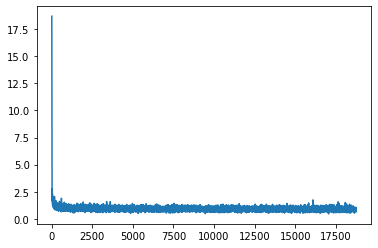

In [29]:
loss5 = list()

for i in range(epoch):
    for x, y in train_loader:
        y_hat = model5(x)
        loss = criterion(y_hat, y)
        loss5.append(loss.item())
        optimizer5.zero_grad()
        loss.backward()
        optimizer5.step()

plt.plot(loss5)

In [30]:
model5.eval()

correct5 = 0

for x, y in test_loader:
    y_pred5 = model5(x)
    
    y_pred5 = torch.argmax(y_pred5, dim=1)
    
    correct5 += torch.sum(y_pred5 == y).item()

print('model5\'s accuracy is %.2f%%' % (100 * correct5 / len(test_data)))

model5's accuracy is 97.16%


### Q5 Using L2 and Dropout

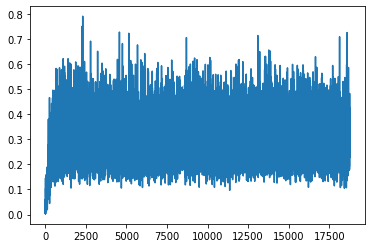

In [31]:
# using model5 and change the optimizer parameter

epoch = 20
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer6 = optim.Adam(model5.parameters(), lr=lr, weight_decay=0.5)

loss6 = list()

for i in range(epoch):
    for x, y in train_loader:
        y_hat = model5(x)
        loss = criterion(y_hat, y)
        loss6.append(loss.item())
        optimizer6.zero_grad()
        loss.backward()
        optimizer6.step()

plt.plot(loss6)

### Q6 Using Default Data

In [43]:
from sklearn.model_selection import train_test_split

data6 = pd.read_csv('Default.txt',sep='\t', header=None)
data6.columns = ['x1', 'x2', 'y']
data = pd.get_dummies(data6, columns=['y'], drop_first=True)

x_data = data[['x1', 'x2']].values
y_data = data['y_Yes'].values

x = torch.tensor(x_data, dtype=torch.float32)
y = torch.tensor(y_data, dtype=torch.float32)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=True)

In [59]:
class Net6(nn.Module):
    def __init__(self):
        super(Net6, self).__init__()
        self.l1 = nn.Linear(2, 64)
        self.l2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.l1(x)
        x = torch.sigmoid(x)
        x = self.l2(x)
        return x

model6 = Net6()

The minimum loss is 0.68


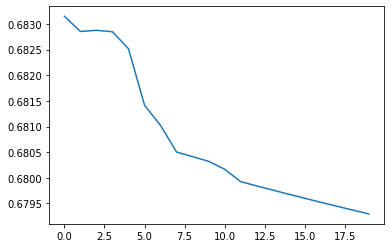

In [60]:
epoch = 20
lr = 1e-3

criterion = nn.BCEWithLogitsLoss()
optimizer6 = optim.SGD(model6.parameters(), lr=lr)

loss6 = list()

for i in range(epoch):
    for x, y in train_loader:
        y_hat = model6(x)
        loss = criterion(y_hat, y.unsqueeze(1))
        loss6.append(loss.item())
        optimizer6.zero_grad()
        loss.backward()
        optimizer6.step()

plt.plot(loss6)
print('The minimum loss is %.2f' % min(loss6))

In [61]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model6.eval()

y_pred6 = list()
y_true6 = list()

for x, y in test_loader:
    y_hat = model6(x)
    y_hat = torch.round(y_hat)
    y_pred6.extend(y_hat.tolist())
    y_true6.extend(y.tolist())

confusion_matrix(y_true6, y_pred6)
print(classification_report(y_true6, y_pred6))

Net6(
  (l1): Linear(in_features=2, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=1, bias=True)
)

array([[ 8,  0],
       [12,  0]], dtype=int64)

              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57         8
         1.0       0.00      0.00      0.00        12

    accuracy                           0.40        20
   macro avg       0.20      0.50      0.29        20
weighted avg       0.16      0.40      0.23        20

